## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [4]:
# DEVICE = torch.device('cpu')
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

## Load data

In [5]:
%run ../datasets/__init__.py

In [6]:
dataset_kwargs = {
    'dataset_name': 'cxr14',
    # 'dataset_name': 'covid-x',
    'dataset_type': 'all',
    'max_samples': None,
    'labels': None, # ['Cardiomegaly'],
}
dataloader = prepare_data_classification(**dataset_kwargs)
dataset = dataloader.dataset
len(dataset)

112113

In [8]:
COVID_SAMPLES = [idx for idx, presence in dataset.get_labels_presence_for('covid') if presence]
len(COVID_SAMPLES)

KeyError: 'covid'

## Load model

In [7]:
%run ../models/checkpoint/__init__.py

### CLS model

In [12]:
# run_name = '0717_120222_covid-x_densenet-121_lr1e-06_os_aug-covid'
# run_name = '0714_030324_covid-x_resnet-50_lr1e-06_os-max14'
# run_name = '0721_214907_cxr14_densenet-121_lr0.001_aug-0_bce_Cardiomegaly_size256'
# run_name = '0721_124730_cxr14_densenet-121_lr1e-05_bce_Cardiomegaly_size256'
# run_name = '1215_174443_cxr14_resnet-50-v2_lr0.0001_os_Cardiomegaly_normS_size256_sch-roc_auc-p5-f0.1'
# run_name = '1205_135045_cxr14_mobilenet-v2_lr0.0001_aug_normS_size256_sch-roc_auc-p5-f0.1'
run_name = '0311_101753_cxr14_densenet-121-v2_drop0.3_normS_wd0.001_size256_sch-roc_auc-p3-f0.1'
debug = False

In [13]:
compiled_model = load_compiled_model_classification(run_name, debug, DEVICE)
_ = compiled_model.model.eval()
compiled_model.metadata['model_kwargs']

{'model_name': 'densenet-121-v2',
 'labels': ['Atelectasis',
  'Cardiomegaly',
  'Effusion',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pneumonia',
  'Pneumothorax',
  'Consolidation',
  'Edema',
  'Emphysema',
  'Fibrosis',
  'Pleural_Thickening',
  'Hernia'],
 'imagenet': True,
 'freeze': False,
 'gpool': 'avg',
 'fc_layers': [],
 'dropout': 0.3}

### CLS-SEG model

In [8]:
run_name = '0402_062551_cxr14_densenet-121-cls-seg_drop0.3_normD_size256_lr5e-05_shuffle_wd0.002_sch-roc_auc-p3-f0.5_best-roc_auc_cl-wbce_seg-w'

In [11]:
compiled_model = load_compiled_model_cls_seg(run_name, debug=False, device=DEVICE)
_ = compiled_model.model.eval()
compiled_model.metadata['model_kwargs']

{'model_name': 'densenet-121-cls-seg',
 'cl_labels': ['Atelectasis',
  'Cardiomegaly',
  'Effusion',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pneumonia',
  'Pneumothorax',
  'Consolidation',
  'Edema',
  'Emphysema',
  'Fibrosis',
  'Pleural_Thickening',
  'Hernia'],
 'seg_labels': ['background', 'heart', 'right lung', 'left lung'],
 'gpool': 'avg',
 'dropout': 0.3}

## Apply Grad-CAM

### Debug grad-cam correctness

In [15]:
import captum
from captum.attr import LayerGradCam, GuidedGradCam, visualization

In [20]:
%run ../training/classification/grad_cam.py
%run ../models/classification/__init__.py
# %run ../utils/common.py

In [29]:
layer = get_last_layer(compiled_model.model)

# grad_cam_with = LayerGradCam(ModelWrapper(compiled_model.model, activation=ACTIVATION), layer)
grad_cam_wo = LayerGradCam(ModelWrapper(compiled_model.model, activation=None), layer)
# grad_cam = GuidedGradCam(Dummy(model), layer)

In [30]:
LABEL_INDEX = 1 # Cardiomegaly

In [31]:
idx = 10

item = dataset[idx]
image = item.image

images = image.unsqueeze(0).to(DEVICE)
images.requires_grad = True
attrs_with = grad_cam_with.attribute(images,
                                     LABEL_INDEX,
                                     relu_attributions=True,
                                    ).detach().cpu().squeeze(0).squeeze(0)
attrs_wo = grad_cam_wo.attribute(images,
                                 LABEL_INDEX,
                                 relu_attributions=True,
                                ).detach().cpu().squeeze(0).squeeze(0)
image.size(), attrs_with.size(), attrs_wo.size()

(torch.Size([3, 512, 512]), torch.Size([16, 16]))

In [26]:
cam_attrs = calculate_cam(compiled_model.model, images)
cam_attrs = cam_attrs.detach().cpu().squeeze(0)[LABEL_INDEX]
cam_attrs.size()

torch.Size([16, 16])

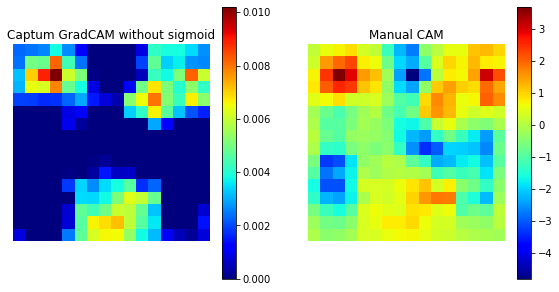

In [28]:
plt.figure(figsize=(15, 5))

# plt.imshow(tensor_to_range01(image).permute(1, 2, 0))
# plt.title(item.image_fname)
# plt.axis('off')

# plt.subplot(1, 3, 1)
# plt.imshow(attrs_with, cmap='jet')
# plt.title(f'Captum GradCAM with {ACTIVATION}')
# plt.axis('off')
# plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(attrs_wo, cmap='jet')
plt.title(f'Captum GradCAM without {ACTIVATION}')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(cam_attrs, cmap='jet')
plt.title('Manual CAM')
plt.axis('off')
plt.colorbar()

In [ ]:
plt.hist((attrs_wo - cam_attrs).view(-1))

### Compute grad-cam

In [12]:
from captum.attr import LayerGradCam, visualization # , GuidedGradCam

from torch import sigmoid
from torch.nn.functional import softmax

In [13]:
%run ../training/classification/grad_cam.py
%run ../utils/common.py

In [14]:
grad_cam = create_grad_cam(compiled_model.model, device=DEVICE)

In [15]:
LABELS = dataset.labels
len(LABELS)

14

In [17]:
def plot_cam(idx, relu=False,
             cmap='jet', show_colorbar=True,
             only=None, cls_thresh=0.3, only_diseases=None,
             **kwargs):
    if only is not None:
        if isinstance(only, str):
            only = (only,)
    
    item = dataset[idx]
    image = item.image
    
    print('Image fname: ', item.image_fname)

    images = image.unsqueeze(0).to(DEVICE)
    # shape: bs=1, 3, height, width

    # Make a prediction
    with torch.no_grad():
        output = compiled_model.model(images)[0].cpu().squeeze()
        # shape: bs=1, n_diseases

    if dataset.multilabel:
        predictions = sigmoid(output).tolist()
        gts = item.labels
    else:
        predictions = softmax(output, dim=-1)
        gts = [
            int(item.labels == i)
            for i in range(len(LABELS))
        ]

    print('Prediction: ', [f"{p:.2f}" for p in predictions])
    print('Ground truth: ', item.labels)

    attributions = calculate_attributions_for_labels(
        grad_cam, images, LABELS, relu=relu).detach().cpu().squeeze()
    # shape: n_labels, height, width
    
    plotable_image = tensor_to_range01(image).permute(1, 2, 0).numpy()
    # shape: height, width, 3
    
    for i, (disease, attr, gt, pred) in enumerate(zip(LABELS, attributions, gts, predictions)):
        if only_diseases is not None and disease not in only_diseases:
            continue

        valoration = pred_and_label_to_valoration((pred > cls_thresh), gt)

        if only is not None and valoration not in only:
            continue
        
        # attr shape: height, width
        attr = attr.unsqueeze(-1).numpy()
        # shape: height, width, 1
        
        title = f'{disease}: gt={gt} pred={pred:.2f} ({valoration})'
        
        fig, ax = visualization.visualize_image_attr_multiple(
            attr, plotable_image, methods=['original_image', 'blended_heat_map'],
            signs=['all', 'all'], titles=['CXR', title],
            cmap=cmap,
            show_colorbar=show_colorbar,
            **kwargs,
           )

    return attributions

Image fname:  00000002_000.png
Prediction:  ['0.30', '0.06', '0.65', '0.57', '0.81', '0.71', '0.10', '0.15', '0.42', '0.04', '0.62', '0.29', '0.40', '0.03']
Ground truth:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


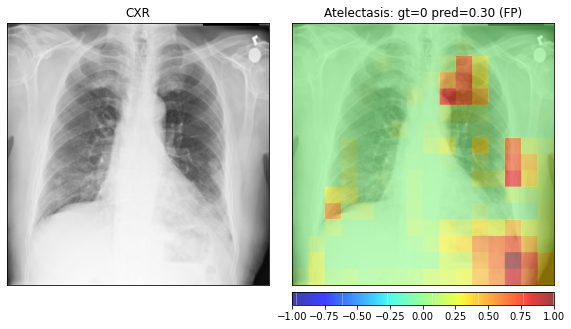

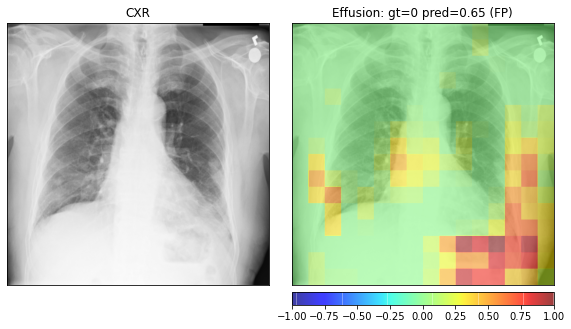

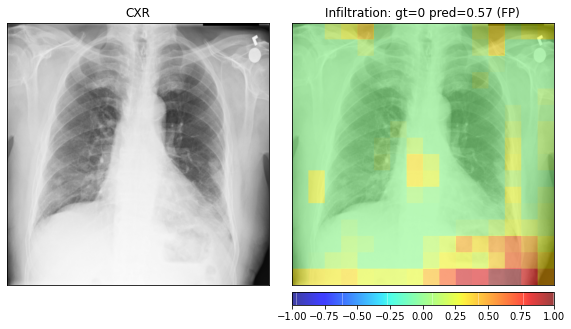

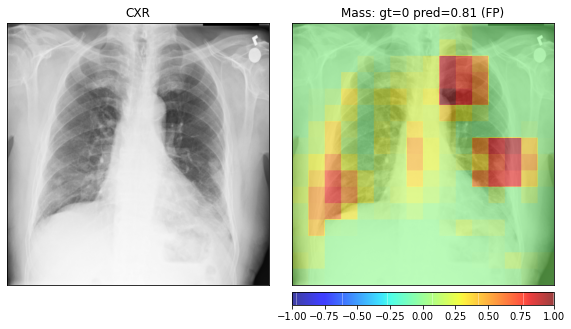

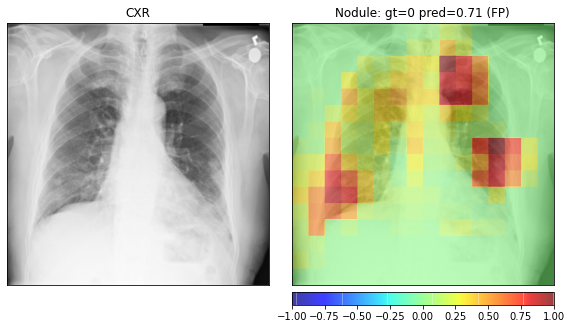

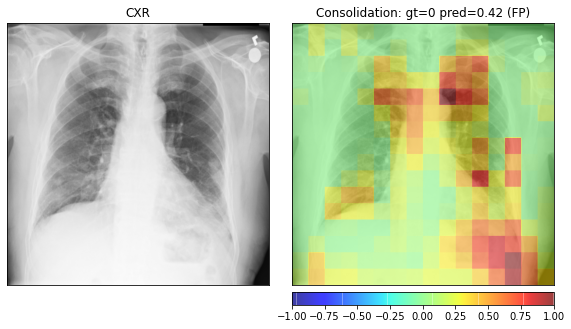

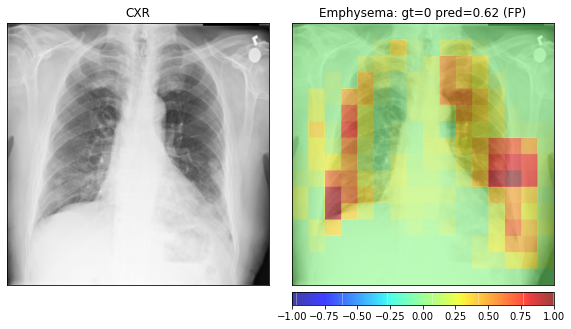

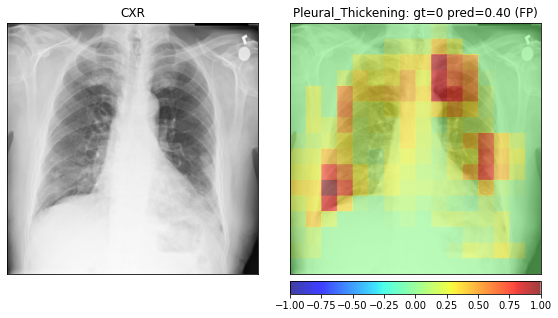

In [20]:
attrs = plot_cam(3, relu=True, only=('TP', 'FP', 'FN'))